# Olas epidémicas

Vamos a analizar diferentes escenarios, de olas epidémicas.




<div class="alert alert-block alert-info">
Cada hipotesis tiene distintos escenarios.
</div>
En cada hipotesis, intentaremos encontrar aquellos umbrales de confinamiento/desconfinamiento que minimicen los valores de olas, días de confinamiento, e infectados totales, por cada escenario de cada hipotesis


In [1]:
import numpy as np
import pandas as pd 
import time
from datetime import datetime, date, time, timedelta
from IPython.display import display, HTML
import matplotlib.dates as mdates
from sklearn.model_selection import GridSearchCV,ParameterGrid
from IPython.display import display, HTML
import janitor

SITUACION_INICIAL = 1
prevalencia = 0 
R0 = 5.7
DIAS_EN_REINFECTAR=5


In [2]:
### Calculamos la capacidad del sistema sanitario.
####Cuanto se tardaria en copar las camas de uci en cada escenario
"""
"Antes de la crisis sanitaria, España disponía de unas 4.500 camas UCI, capacidad que aumentó hasta las 8.000"
Madrid cuenta con 1.750 camas
Cataluña tiene 1.722 camas
Andalucía con 1.200 camas.
Canarias cuenta con 595 camas.
Euskadi con capacidad para 550 camas. 
Castilla-León tiene 500 camas.
Aragón con 300 camas.
Castilla-La Mancha cuenta con 300 camas.
Galicia tiene 274 camas.
Comunidad Valenciana con 254 plazas libres.
Navarra con 156 camas. 
Murcia tiene 123 camas. 
Baleares con 120 camas.
Extremadura cuenta con 100 camas.
Cantabria con 64 camas.
Asturias cuenta con 61 camas. 
La Rioja tiene 23 plazas. 
TOTAL = 8092
"""

"De los 11.424 pacientes de Covid-19 ingresados en Madrid, según datos del Ministerio de Sanidad, 1.332 están en la UCI, un 11,7%."
"Si para una prevalencia de 10% (750000 personas para la comunidad de madrid)"

# Calculamos la capacidad del sistema sanitario - el nº de enfermos que puede haber antes de que colapse
NUMERO_CAMAS_UCI=8092 

PORCENTAJE_ENFERMOS_NECESITADOS_HOSPITALIZACION = 0.088 # https://www.redaccionmedica.com/secciones/sanidad-hoy/coronavirus-en-personal-sanitario-hospitalizacion-en-el-8-8-de-casos-9925
PORCENTAJE_HOSPITALIZADOS_NECESITADOS_UCI = 0.05  #https://www.elperiodico.com/es/sociedad/20200316/coronavirus-hospitalizados-graves-contagio-7891866

CAPACIDAD_SISTEMA_SANITARIO = NUMERO_CAMAS_UCI / PORCENTAJE_ENFERMOS_NECESITADOS_HOSPITALIZACION / PORCENTAJE_HOSPITALIZADOS_NECESITADOS_UCI
CAPACIDAD_SISTEMA_SANITARIO = int(CAPACIDAD_SISTEMA_SANITARIO)

print ("La estimacion de la capacidad del sistema sanitario es " , CAPACIDAD_SISTEMA_SANITARIO ) 


La estimacion de la capacidad del sistema sanitario es  1839090


In [3]:
def Get_Header(GENERACIONES,df,FECHA_INICIAL_STR = '2020-02-01'):
    array_fechas = []
    FECHA_INICIAL = datetime.strptime(FECHA_INICIAL_STR, "%Y-%m-%d")
    modified_date = FECHA_INICIAL
    NUM_GENERACIONES = range(1,GENERACIONES)
    for generacion in NUM_GENERACIONES:
        modified_date += timedelta(days=DIAS_EN_REINFECTAR)
        array_fechas.append(datetime.strftime(modified_date, "%Y-%m-%d"))
    df.columns = array_fechas
    return df

def Calcular_Cuadro_Prevalencias( R0,GENERACIONES,ARRAY_PREVALENCIAS, SITUACION_INICIAL=1,FECHA_INICIAL_STR = '2020-02-01',DEBUG=False):
    if DEBUG : 
        print (f""" Calcular_Cuadro_Prevalencias infectados_en_esta_generacion {R0},{GENERACIONES},{ARRAY_PREVALENCIAS}, {SITUACION_INICIAL}, {FECHA_INICIAL_STR} """)
    diccionario_prevalencias = {}
    array=[]

    for prevalencia in ARRAY_PREVALENCIAS : 
        infectados_en_esta_generacion = SITUACION_INICIAL
        NUM_GENERACIONES = range(1,GENERACIONES)
        array=[]
        for generacion in NUM_GENERACIONES:
            prevalencia_esta_iteracion =  min(45000000,np.sum(array)) / 45000000
            if DEBUG : print ("infectados_en_esta_generacion",infectados_en_esta_generacion,R0,prevalencia,prevalencia_esta_iteracion)
            infectados_en_esta_generacion = int(infectados_en_esta_generacion * R0 * max(0,( 1 - (prevalencia + prevalencia_esta_iteracion)) ) )
            array.append(infectados_en_esta_generacion)
        diccionario_prevalencias['prevalencia ' + str("{:.1f}".format(prevalencia)) + ' y R0 ' + str(R0)] = array
    df = pd.DataFrame.from_dict(diccionario_prevalencias,'index')    
    df = Get_Header(GENERACIONES,df,FECHA_INICIAL_STR)
    df = df.astype(np.int64)
    return df.T


In [4]:
# Auxiliary functions
def interpolate_dataframe(df,freq):
    if freq == 'H':
        rng = pd.date_range(df.index.min(), df.index.max() + pd.Timedelta(23, 'H'), freq='H')
    elif freq == 'D' :  
        rng = pd.date_range(
            datetime.strptime(str(df.index.min())[:10]+' 00:00:00', "%Y-%m-%d %H:%M:%S") ,
            datetime.strptime(str(df.index.max())[:10]+' 00:00:00', "%Y-%m-%d %H:%M:%S"), 
            freq='D')
        df.index = pd.to_datetime(df.index)  
    df2 = df.reindex(rng)
    df = df2
    for column in df.columns :
        s = pd.Series(df[column])
        s.interpolate(method="quadratic", inplace =True)
        df[column] = pd.DataFrame([s]).T
    df.index.name = 'Fecha'
    return df


In [5]:
# first execution
GENERACIONES=8
ARRAY_PREVALENCIAS = np.linspace(0,0.70,8)
ARRAY_PREVALENCIAS




array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

In [6]:
   
from matplotlib import pyplot as plt    
import pandas as pd
import numpy as np

def Get_Chart(df, title="default", xlabel="" ):
    fig = plt.figure(figsize=(8, 6), dpi=80)

    for ca in df.columns:
        plt.plot(df[ca])
        plt.legend(df.columns)
        fig.suptitle(title, fontsize=20)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.xticks(rotation=45)
    plt.gca().set_xlabel(xlabel)
    return plt



In [7]:
#### PRedicciones a futuro

"""
Crear 30.
Borrar las mayores de umbral superios.
Aplicar hasta que haya menos de x
"""
from datetime import date
GENERACIONES=15

def calcular_prevision(**kwargs) :
    """FECHA_FINAL_STR,
    FECHA_INICIAL_STR,
    SITUACION_INICIAL,
    POBLACION_INICIAL_INFECTADA,
    R0_max,
    R0_min,
    Umbral_max,
    Umbral_min):
"""
    FECHA_FINAL_STR              = kwargs.pop('FECHA_FINAL_STR')
    FECHA_INICIAL_STR            = kwargs.pop('FECHA_INICIAL_STR')
    SITUACION_INICIAL            = kwargs.pop('SITUACION_INICIAL')
    POBLACION_INICIAL_INFECTADA  = kwargs.pop('POBLACION_INICIAL_INFECTADA')
    R0_max                       = kwargs.pop('R0_max')
    R0_min                       = kwargs.pop('R0_min')
    RO_calor                     = kwargs.pop('RO_calor',1.702 )
    Umbral_max                   = kwargs.pop('Umbral_max')
    Umbral_min                   = kwargs.pop('Umbral_min')
    GENERACIONES_SUBIDA          = kwargs.pop('GENERACIONES_SUBIDA',16)
    GENERACIONES_BAJADA          = kwargs.pop('GENERACIONES_BAJADA',22)
    INCREMENTOS_IMPORTADOS_CADA_ITERACION = kwargs.pop('INCREMENTOS_IMPORTADOS_CADA_ITERACION',50)
    DEBUG                        = kwargs.pop('DEBUG',False)

    
    
    
    if DEBUG:  print(  f"""FECHA_FINAL_STR={FECHA_FINAL_STR},
        FECHA_INICIAL_STR={FECHA_INICIAL_STR},
        SITUACION_INICIAL={SITUACION_INICIAL},
        POBLACION_INICIAL_INFECTADA={POBLACION_INICIAL_INFECTADA},
        R0_max={R0_max},
        R0_min={R0_min},
        Umbral_max={Umbral_max},
        Umbral_min={Umbral_min}""")
    df_temp = pd.DataFrame()
    df = pd.DataFrame(columns = ['Infectados'])    
    
    #
    while FECHA_INICIAL_STR < FECHA_FINAL_STR :

        df_temp = pd.DataFrame()
        PREVALENCIA = (POBLACION_INICIAL_INFECTADA + df.iloc[:,0].sum()) /45000000
        ARRAY_PREVALENCIAS = []
        ARRAY_PREVALENCIAS.append(PREVALENCIA)

        # Subida
        # En verano cambian los parámetros
        PERIODO_CALOR = ( FECHA_INICIAL_STR[5:] > '06-15' ) & ( FECHA_INICIAL_STR[5:] <  '09-15' )
        R0_DESCONTADO_CALOR = min(R0_max,RO_calor) if PERIODO_CALOR else R0_max
        GENERACIONES_SUBIDA = 30       if PERIODO_CALOR else kwargs.pop('GENERACIONES_SUBIDA',16)

        if DEBUG:  print(f""" subida SITUACION_INICIAL={SITUACION_INICIAL},
            R0                 = {R0_DESCONTADO_CALOR} ,
            GENERACIONES       = {GENERACIONES_SUBIDA} ,
            ARRAY_PREVALENCIAS = {ARRAY_PREVALENCIAS}  ,
            FECHA_INICIAL_STR  = {FECHA_INICIAL_STR} ,
            df_shape           = {df.shape[0]}   """)
        df_temp =  Calcular_Cuadro_Prevalencias( 
            DEBUG = False,
            SITUACION_INICIAL  = SITUACION_INICIAL   ,
            R0                 = R0_DESCONTADO_CALOR ,
            GENERACIONES       = GENERACIONES_SUBIDA ,
            ARRAY_PREVALENCIAS = ARRAY_PREVALENCIAS  ,
            FECHA_INICIAL_STR  = FECHA_INICIAL_STR )  

        # Borramos las siguientes
        
        df_temp['Infectados'] = df_temp.iloc[:,0]
        df_temp = df_temp[['Infectados']]

        HACEMOS_LA_BAJADA =df_temp['Infectados'].max() > Umbral_max
        if  df_temp[(df_temp['Infectados'] > (Umbral_max*1) )].size > 0  :
            FECHA_DESDE_LA_QUE_BORRAR = df_temp[(df_temp['Infectados'] > (Umbral_max*1) )].index[0]
            otro_index = [fecha for fecha in df_temp.index if fecha < FECHA_DESDE_LA_QUE_BORRAR ]
            df_temp = df_temp.head(len(otro_index))

            df_temp.dropna()
            df_temp = df_temp.loc[~df_temp.index.duplicated(keep='last')]
            df_temp = pd.DataFrame(df_temp)

        df = pd.concat([df_temp,df])
        df = df.sort_index()

        SITUACION_INICIAL = df.iloc[-1]['Infectados']
        df.Infectados.iat[-1] += INCREMENTOS_IMPORTADOS_CADA_ITERACION
        
        # Bajada        
        if HACEMOS_LA_BAJADA :           
            PREVALENCIA = (POBLACION_INICIAL_INFECTADA + df.iloc[:,0].sum()) /45000000
            ARRAY_PREVALENCIAS = []
            ARRAY_PREVALENCIAS.append(PREVALENCIA)
            FECHA_INICIAL_STR = df.index[-1]
            df_temp = pd.DataFrame()

            if DEBUG:  print(f""" bajada SITUACION_INICIAL={SITUACION_INICIAL},
                R0                 = {R0_min} ,
                GENERACIONES       = {GENERACIONES_BAJADA} ,
                ARRAY_PREVALENCIAS = {ARRAY_PREVALENCIAS}  ,
                FECHA_INICIAL_STR  = {FECHA_INICIAL_STR} ,
                df_shape           = {df.shape[0]}   """)
            df_temp =  Calcular_Cuadro_Prevalencias(
                DEBUG              = False,
                SITUACION_INICIAL  = SITUACION_INICIAL,
                R0                 = R0_min,
                GENERACIONES       = GENERACIONES_BAJADA,
                ARRAY_PREVALENCIAS = ARRAY_PREVALENCIAS,
                FECHA_INICIAL_STR  = FECHA_INICIAL_STR )
            
            # Borramos las siguientes
            df_temp['Infectados'] = df_temp.iloc[:,0]
            df_temp = df_temp[['Infectados']]
            if  df_temp[(df_temp['Infectados'] < (Umbral_min*1) )].size > 0  :
                FECHA_DESDE_LA_QUE_BORRAR = df_temp[(df_temp['Infectados'] < (Umbral_min*1) )].index[0]
                otro_index = [fecha for fecha in df_temp.index if fecha < FECHA_DESDE_LA_QUE_BORRAR ]
                df_temp = df_temp.head(len(otro_index))
                

            df_temp = pd.DataFrame(df_temp)
            df = pd.concat([df_temp,df])
            df = df.sort_index()
            SITUACION_INICIAL = df.iloc[-1]['Infectados']
            #return df,df_temp
        FECHA_INICIAL_STR = df.index[-1]
        df.Infectados.iat[-1] += INCREMENTOS_IMPORTADOS_CADA_ITERACION
        if DEBUG:  print(f""" iteracion :  df_shape= {df.shape[0]}  ,FECHA_INICIAL_STR={FECHA_INICIAL_STR} , FECHA_FINAL_STR={FECHA_FINAL_STR}""")


            
    FECHA_DESDE_LA_QUE_BORRAR = FECHA_FINAL_STR
    otro_index = [fecha for fecha in df.index if fecha <= FECHA_DESDE_LA_QUE_BORRAR ]
    df = df.head(len(otro_index))

    df = df[df > 0].dropna()
    df = df.dropna()
    df = df.loc[~df.index.duplicated(keep='last')]
    if DEBUG:  print(f""" final :  df_shape= {df.shape[0]}  ,FECHA_INICIAL_STR={FECHA_INICIAL_STR} , FECHA_FINAL_STR={FECHA_FINAL_STR}""")
    return df 
    

"""
SITUACION_INICIAL           = 1000
POBLACION_INICIAL_INFECTADA = 4500000
R0_max                      = 5.7 
R0_min                      = 0.5
Umbral_max                  = CAPACIDAD_SISTEMA_SANITARIO 
Umbral_min                  = 10000
FECHA_INICIAL_STR           = '2020-07-01'
FECHA_FINAL_STR             = '2021-01-01'
"""
SITUACION_INICIAL =10000
POBLACION_INICIAL_INFECTADA=4500000
R0_max=5.7
R0_min=0.5
Umbral_max=1839090
Umbral_min=5000
FECHA_FINAL_STR   ='2021-07-01'
FECHA_INICIAL_STR ='2020-07-01'



df = calcular_prevision(
    FECHA_FINAL_STR = FECHA_FINAL_STR,
    FECHA_INICIAL_STR = FECHA_INICIAL_STR,
    SITUACION_INICIAL = SITUACION_INICIAL,
    POBLACION_INICIAL_INFECTADA =  POBLACION_INICIAL_INFECTADA,
    R0_max = R0_max,
    R0_min =  R0_min,
    Umbral_max =  Umbral_max,
    Umbral_min =  Umbral_min,
    DEBUG=False)

#df

In [8]:
# DEBUG
#SITUACION_INICIAL  = 1000
#R0_min             = 1.702 
#GENERACIONES_BAJADA= 30 
#ARRAY_PREVALENCIAS = [0.1]  
#FECHA_INICIAL_STR  = '2020-07-01'

#df_temp =  Calcular_Cuadro_Prevalencias( 
#  	R0                 = R0_min,
#	GENERACIONES       = GENERACIONES_BAJADA,
#	ARRAY_PREVALENCIAS = ARRAY_PREVALENCIAS,
#	SITUACION_INICIAL  = SITUACION_INICIAL,
#	FECHA_INICIAL_STR  = FECHA_INICIAL_STR    ,
#    DEBUG              = False )


 

<h2>Analizamos la <strong>primera hipotesis</strong>.</h2>

Que pasaría si <strong>la infectividad del virus es de una R0 de 5.7</strong>. Tenemos varios escenario de R0, con/sin mascarilla, con/sin distanciamiento.

Estos son los peores escenarios.

Solo confinamos cuando superamos la capacidad hospitalaria, desconfinamos hasta que llegamos a 5000 nuevas infecciones en 5 días 

Estos escenarios son solo una <strong>linea base</strong>, para ver cuanto optimizamos si no tomamos decisiones de confinamiento/desconfinamiento.



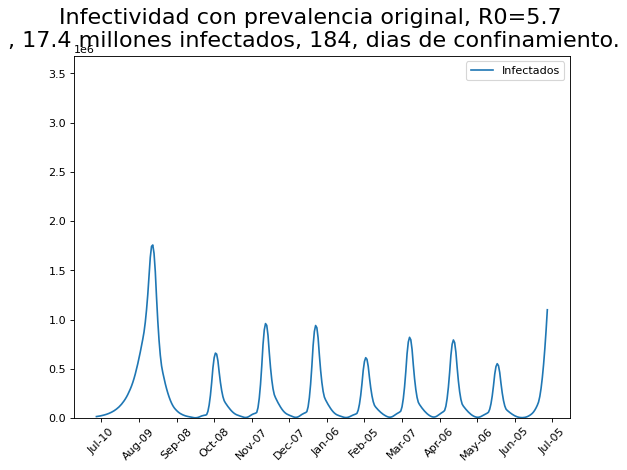

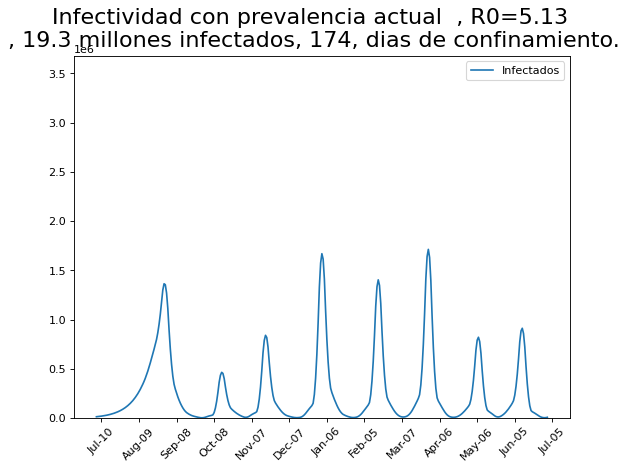

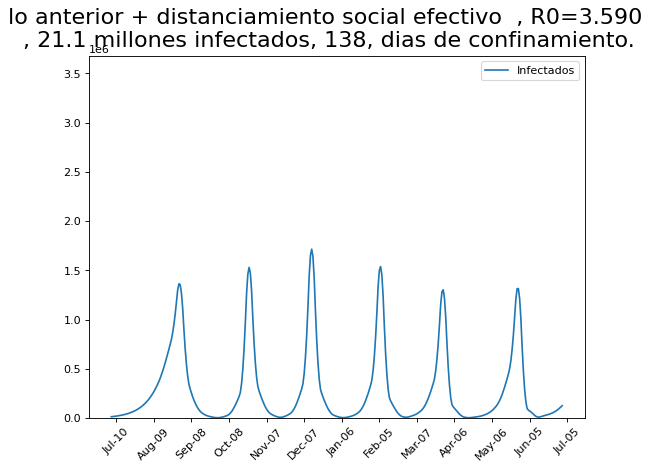

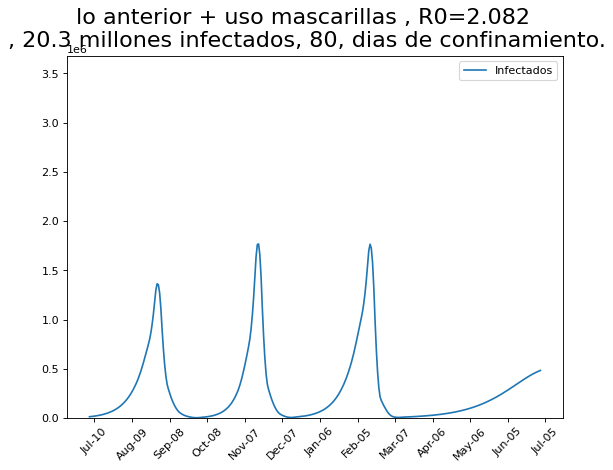

In [9]:
""" diccionario_R0s = {"Infectividad con prevalencia original, R0=5.7" : { R0 : 5.7, POBLACION_INICIAL_INFECTADA : 4500000} ,  
"lo anterior + distanciamiento social efectivo , R0=3.590"  : 3.590,   
"lo anterior + uso mascarillas , R0=2.082" : 2.082   ,                 
"lo anterior + temperaturas de verano , R0=1.707" : 1.702             
}

Infectividad primera ola , R0=5.7                           223383
lo anterior + distanciamiento social efectivo , R0=3.989     83430
lo anterior + uso mascarillas , R0=2.314                     20062
lo anterior + temperaturas de verano , R0=1.897              12331
lo anterior + confinamiento , R0=0.5                           875
"""
array_parametros = [
    { "descripcion" : "Infectividad con prevalencia actual  , R0=5.13"            , 'R0' : 5.7   , 'POBLACION_INICIAL_INFECTADA' : 4500000} 
 ]
array_parametros = [
    { "descripcion" : "Infectividad con prevalencia original, R0=5.7"             , 'R0' : 5.7   , 'POBLACION_INICIAL_INFECTADA' : 0} ,
    { "descripcion" : "Infectividad con prevalencia actual  , R0=5.13"            , 'R0' : 5.7   , 'POBLACION_INICIAL_INFECTADA' : 4500000} ,
    { "descripcion" : "lo anterior + distanciamiento social efectivo  , R0=3.590" , 'R0' : 3.989 , 'POBLACION_INICIAL_INFECTADA' : 4500000} ,
    { "descripcion" : "lo anterior + uso mascarillas , R0=2.082"                  , 'R0' : 2.314 , 'POBLACION_INICIAL_INFECTADA' : 4500000} ,
]


df_array = []

dict_default_values = {
    "SITUACION_INICIAL" : 10000                        ,
    "R0_min"            :     0.5                      ,
    "Umbral_max"        :  CAPACIDAD_SISTEMA_SANITARIO , 
    "Umbral_min"        :  5000                        ,
    "FECHA_INICIAL_STR" : '2020-07-01'                 ,
    "FECHA_FINAL_STR"   : '2021-07-01'
}

def get_interpolated_days(df_temp):
    df_interpolated=interpolate_dataframe(df_temp,'D')
    return df_interpolated.shape[0] - (df_interpolated['Infectados'] - df_interpolated['Infectados'].shift(1) > 0).sum()  


for dict_escenario in array_parametros:
    ## Juntamos los valores por defecto, y los que cambian cada vez.
    param = {**dict_escenario, ** dict_default_values}
    #print(param)

    df_temp = pd.DataFrame()
    df_temp = calcular_prevision(
        FECHA_FINAL_STR             = param['FECHA_FINAL_STR'            ], 
        FECHA_INICIAL_STR           = param['FECHA_INICIAL_STR'          ], 
        SITUACION_INICIAL           = param['SITUACION_INICIAL'          ], 
        POBLACION_INICIAL_INFECTADA = param['POBLACION_INICIAL_INFECTADA'],
        R0_max                      = param['R0'                         ], 
        R0_min                      = param['R0_min'                     ], 
        Umbral_max                  = param['Umbral_max'                 ], 
        Umbral_min                  = param['Umbral_min'                 ]  ,
        DEBUG = False
    )
    df_temp
    
    df_temp = df_temp.astype(np.int64)
    df_temp = df_temp.loc[~df_temp.index.duplicated(keep='last')]
    infectados_totales = int(df_temp.astype(int).sum(axis=0))
    #print(param['descripcion'], df_temp.tail(1).index[-1],"suma: " , suma)
    df_array.append(df_temp) 
    DIAS_CONFINAMIENTO = get_interpolated_days(df_temp)

    plt = Get_Chart(df=interpolate_dataframe(df_temp,'D'), 
                    title = param['descripcion'] +" \n, "+ str(infectados_totales/1000000)[:4] + " millones infectados, " +  str(DIAS_CONFINAMIENTO) + ", dias de confinamiento." ) 
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))

    ax = plt.gca()
    ax.set_ylim([0,Umbral_max*2])
    param = {}
    
df  =  pd.concat(df_array)
#df_temp

In [10]:
##### solo debug
def debug_Calcular_Cuadro_Prevalencias():
    SITUACION_INICIAL=829339
    R0                 = 5.7 
    GENERACIONES       = 15        
    ARRAY_PREVALENCIAS = [0.10]  
    FECHA_INICIAL_STR  = '2020-10-04'


    return Calcular_Cuadro_Prevalencias( SITUACION_INICIAL  = SITUACION_INICIAL   ,
                R0                 = R0 ,
               GENERACIONES       = GENERACIONES        ,
                ARRAY_PREVALENCIAS = ARRAY_PREVALENCIAS  ,
                FECHA_INICIAL_STR  = FECHA_INICIAL_STR )

# debug_Calcular_Cuadro_Prevalencias() 

In [11]:

import pickle

def simulation_save_to_file(objeto,nombre_fichero):
    pickle.dump(objeto, open(nombre_fichero, 'wb'))

def simulation_get_from_file(nombre_fichero):
    return pickle.load(open(nombre_fichero, 'rb'))




In [12]:
def get_results_singlechart_simulacion(results_array,criterio,puesto,mejores_resultados=True):
    df_results = pd.DataFrame(results_array)
    df_results.sort_values(criterio, inplace=True,ascending=mejores_resultados)
    row     = df_results.iloc[puesto]

    ### Get Parameters from simulation
    df_temp            = pd.DataFrame(row.df)
    suma               = row.infectados_totales
    dias_confinamiento = row.dias_confinamiento
    infectados_totales = '%.2f' % ( row.infectados_totales /1000000)
    numero_de_olas     = row['numero_de_olas']
    descripcion        = row['descripcion']
    umbral_maximo      = row['Umbral_max']
    umbral_minimo      = row['Umbral_min']
    
    lugar = int(puesto) + int(1)
    df_array.append(df_temp) 
    #print (f"""criterio: {criterio}, puesto: {lugar}, descripcion {descripcion}, umbral_maximo: {umbral_maximo},umbral_minimo: {umbral_minimo}, 
    #infectados_totales: {infectados_totales}, dias_confinamiento: {dias_confinamiento}, numero_de_olas: {numero_de_olas})
    #""" )
    plt = Get_Chart(df=interpolate_dataframe(df_temp,'D'), 
                title  = f"""{descripcion}, {lugar}º en {criterio}""",
                xlabel = f"""infectados: {infectados_totales}, dias de confinamiento: {dias_confinamiento},Umbrales: ({umbral_maximo},{umbral_minimo}), olas {numero_de_olas}""")

    #plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
    return plt


In [13]:
import matplotlib.pyplot as plt
import pandas as pd 
import matplotlib.dates as mdates

def Get_Chart2(df, title="default", xlabel="", ax=None,f=None):
    if ax is None:
        ax = plt.gca()
    plt.axes(ax)
    for ca in df.columns:
        plt.plot(df[ca])
        plt.legend(df.columns)
        f.suptitle(title, fontsize=20)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
    plt.xticks(rotation=45)
    plt.gca().set_xlabel(xlabel,horizontalalignment='center')
    return plt


def get_results_multichart_simulacion2(f, axes,results_array,criterio,puesto,mejores_resultados=True):
    """ Obtiene los n puestos mejores por un criterio.
    Selecciona los df y genera el array de graficos aosciado"""
    df_results = pd.DataFrame(results_array)
    for puesto in range(puesto): 
        df_results.sort_values(criterio, inplace=True,ascending=mejores_resultados)
        row     = df_results.iloc[puesto]

        ### Get Parameters from simulation
        df_temp            = pd.DataFrame(row.df)
        suma               = row.infectados_totales
        dias_confinamiento = row.dias_confinamiento
        infectados_totales = '%.2f' % ( row.infectados_totales /1000000)
        numero_de_olas     = row['numero_de_olas']
        descripcion        = row['descripcion']
        umbral_maximo      = row['Umbral_max']
        umbral_minimo      = row['Umbral_min']
    
        lugar = int(puesto) + int(1)


        plt = Get_Chart2( ax=axes[puesto],f=f, df=interpolate_dataframe(df_temp,'D'), 
                    title  = f"""{descripcion}, {lugar} mejores resultados en: {criterio}""",
                    xlabel = f"""infectados: {infectados_totales} mill.,  olas {numero_de_olas}
dias de confinamiento: {dias_confinamiento},
Umbrales confinar/desconfinar:
({umbral_maximo},{umbral_minimo})""")

    return plt

def debug_get_results_multichart_simulacion2():
    for criterio in ['dias_confinamiento','numero_de_olas','infectados_totales']:
        f, axes = plt.subplots(1 , 4 ,figsize=(16, 4), sharex=True)

        get_results_multichart_simulacion2(f=f, axes=axes,results_array=results_array,
                                 criterio =criterio,
                                puesto=4
                                )


In [14]:
import pickle
from tqdm.notebook import tqdm


def generate_results_simlation(dict_escenario, dict_default_values) :
    df_array = []

    

    grid = ParameterGrid({"Umbral_max": [1800000, 
                                         1000000,
                                          750000,
                                          500000,
                                          250000,
                                          125000,
                                          62000,
                                         ],
 #                         "Umbral_min": [5000] } )
                           "Umbral_min": [5000, 10000,20000,40000,50000] } )

     

    results_array = [ ]

    for grid_params in  tqdm(grid, desc= dict_escenario['descripcion']) : 
        params = {**grid_params, **dict_escenario, ** dict_default_values}
        
        if  params['Umbral_max'] <  params['Umbral_min']          : continue
        if (params['Umbral_max'] / params['Umbral_min']) <= 2.50  : continue
        if (params['Umbral_max'] - params['Umbral_min']) < 25000  : continue        
        # Si hay una situacion donde no puedas ir ni hacia arriba ni hacia abajo
        if (params['Umbral_max'] / params['Umbral_min']) <  params['R0'] / params['R0_min']   : continue
        ## Juntamos los valores por defecto, y los que cambian cada vez.
        #print(grid_params,dict_escenario["descripcion"])
        this_iteration_result = {}
        df_temp = pd.DataFrame()
        df_temp = calcular_prevision(
            FECHA_INICIAL_STR           = params['FECHA_INICIAL_STR'          ], 
            FECHA_FINAL_STR             = params['FECHA_FINAL_STR'            ], 
            SITUACION_INICIAL           = params['SITUACION_INICIAL'          ], 
            POBLACION_INICIAL_INFECTADA = params['POBLACION_INICIAL_INFECTADA'],
            R0_max                      = params['R0'                         ], 
            R0_min                      = params['R0_min'                     ], 
            Umbral_max                  = params['Umbral_max'                 ], 
            Umbral_min                  = params['Umbral_min'                 ]  
        )
        # Prepare results
        # Dataframe level
        df_temp = df_temp.astype(np.int64)
        df_temp = df_temp.loc[~df_temp.index.duplicated(keep='last')]
        # Calculate results
        infectados_totales = int(df_temp.astype(int).sum(axis=0))
        df_temp['Diferencia'] =  df_temp['Infectados'] - df_temp['Infectados'].shift(1)

        dias_confinamiento = get_interpolated_days(df_temp)

        numero_de_olas = (( df_temp['Diferencia'] < 0) & (df_temp['Diferencia'].shift(1) > 0 )  ).sum()   
        # Store results
        this_iteration_result['escenario']        = dict_escenario["escenario"]
        this_iteration_result['descripcion']        = dict_escenario["descripcion"]
        this_iteration_result['Umbral_max']         = params['Umbral_max']
        this_iteration_result['Umbral_min']         = params['Umbral_min']
        this_iteration_result['dias_confinamiento'] = dias_confinamiento
        this_iteration_result['numero_de_olas'    ] = numero_de_olas
        this_iteration_result['infectados_totales'] = infectados_totales
        this_iteration_result['R0']                 = params['R0']
        this_iteration_result['R0_min']             = params['R0_min']
        this_iteration_result['FECHA_INICIAL_STR']  = params['FECHA_INICIAL_STR']
        this_iteration_result['FECHA_FINAL_STR']    = params['FECHA_FINAL_STR']
        this_iteration_result['SITUACION_INICIAL']  = params['SITUACION_INICIAL']
        this_iteration_result['POBLACION_INICIAL_INFECTADA'] = params['POBLACION_INICIAL_INFECTADA']
        this_iteration_result['df']                 = df_temp['Infectados']
          
        #print(this_iteration_result)
        results_array.append(this_iteration_result) 
    return results_array

def simulation_save_to_file(objeto,nombre_fichero):
    pickle.dump(objeto, open(nombre_fichero, 'wb'))


    



def Generar_Datos_Conjunto_Escenarios(array_parametros,dict_default_values,title):
    display(HTML("<h1>"+title+"</h1>"))

    all_results_array=[]
    # Por cada escenario, generamos las respuestas, y obtenemos las mejores por     dias_confinamiento','numero_de_olas','infectados_totales'
    for i,escenario in  tqdm(enumerate(array_parametros), desc="Procesando escenarios") :
        results_array = []    
        results_array = generate_results_simlation(escenario,dict_default_values)
        all_results_array += results_array
        #print(" Escenario: "+ escenario['descripcion'])

        simulation_save_to_file(results_array,"simulacion_"+str(i)+".pickle")
        for criterio in ['dias_confinamiento','numero_de_olas','infectados_totales']:
            f, axes = plt.subplots(1 , 4 ,figsize=(16, 4), sharex=True)

            get_results_multichart_simulacion2(f=f, axes=axes,results_array=results_array,
                                     criterio =criterio,
                                    puesto=4
                                    )

    simulation_save_to_file(all_results_array,title+"last_scenary_all.pickle")
    return all_results_array

In [17]:
### Workin

def Generar_Datos_Conjunto_Escenarios(array_parametros,dict_default_values,title):
    display(HTML("<h1>"+title+"</h1>"))

    all_results_array=[]
    # Por cada escenario, generamos las respuestas, y obtenemos las mejores por     dias_confinamiento','numero_de_olas','infectados_totales'
    for i,escenario in  tqdm(enumerate(array_parametros), desc="Procesando escenarios") :
        results_array = []    
        results_array = generate_results_simlation(escenario,dict_default_values)
        all_results_array += results_array
        #print(" Escenario: "+ escenario['descripcion'])
        simulation_save_to_file(results_array,"/tmp/simulacion_"+str(i)+".pickle")
    simulation_save_to_file(all_results_array,"/tmp/"+title+"last_scenary_all.pickle")
    

    return all_results_array


def Generar_Graficos(results_array,escenario,criterio):
    f, axes = plt.subplots(1 , 4 ,figsize=(16, 4), sharex=True)

    get_results_multichart_simulacion2(f=f, axes=axes,results_array=results_array,
                             criterio =criterio,
                            puesto=4
                            )

def Extraer_Escenario_From_Resultados(all_results_array,escenario,criterio,elementos=5):
    """Extraer los resultados de un escenario y un criterio"""
    all_results_df   = pd.DataFrame(all_results_array)
    df_escenario     = all_results_df.filter_on(f"""descripcion == '{escenario}'"""  )
    array_criterios  = [ ]
    criterios_order  = [ ]
    if criterio == 'infectados_totales' :
        array_criterios      =  [ 'infectados_totales', 'numero_de_olas']
        array_criterio_order =  [ True, True ]
    elif  criterio == 'dias_confinamiento' :
        array_criterios      =  [ 'dias_confinamiento' ,'infectados_totales' ]
        array_criterio_order =  [ True, True]
    elif criterio == 'numero_de_olas' :
        array_criterios      =  [ 'numero_de_olas', 'infectados_totales' ]
        array_criterio_order =  [ True, True] 
    #print("ordenamos ",escenario, array_criterios,array_criterio_order)
    df_escenario.sort_values(by = array_criterios,ascending=array_criterio_order ,inplace=True)
    return df_escenario.head(elementos)    


def Mostrar_Resultados_Conjunto_Escenarios(all_results_array, ordenar='criterio'):
    # Extraemos resultados
    lista_escenarios = pd.DataFrame(all_results_array).descripcion.unique()
    if  ordenar == 'criterio':
        for criterio in ['infectados_totales','dias_confinamiento','numero_de_olas']:
            for escenario in  lista_escenarios:
                escenario_results_array = Extraer_Escenario_From_Resultados(all_results_array,escenario,criterio,elementos=5)  
                Generar_Graficos(escenario_results_array,escenario,criterio)
    else :
        for escenario in  lista_escenarios:
            for criterio in ['dias_confinamiento','numero_de_olas','infectados_totales']:
                escenario_results_array = Extraer_Escenario_From_Resultados(all_results_array,escenario,criterio,elementos=5)  
                Generar_Graficos(escenario_results_array,escenario,criterio)        




/root/anaconda2/envs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


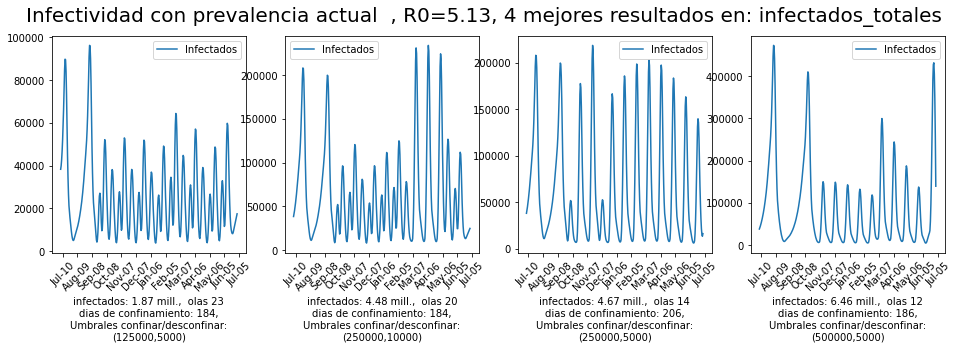

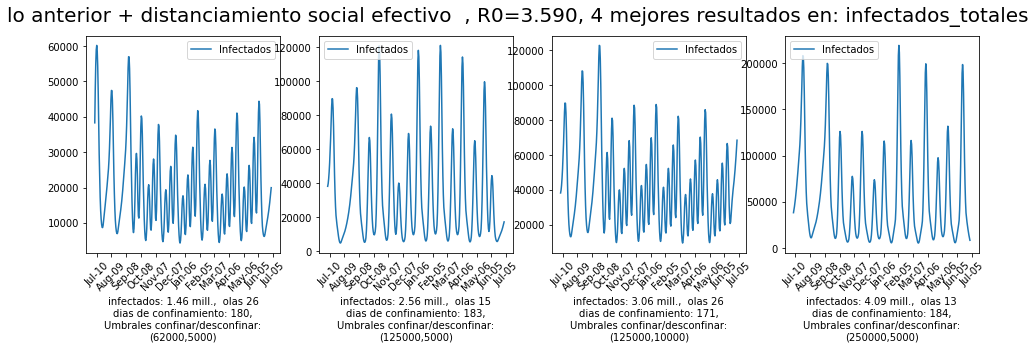

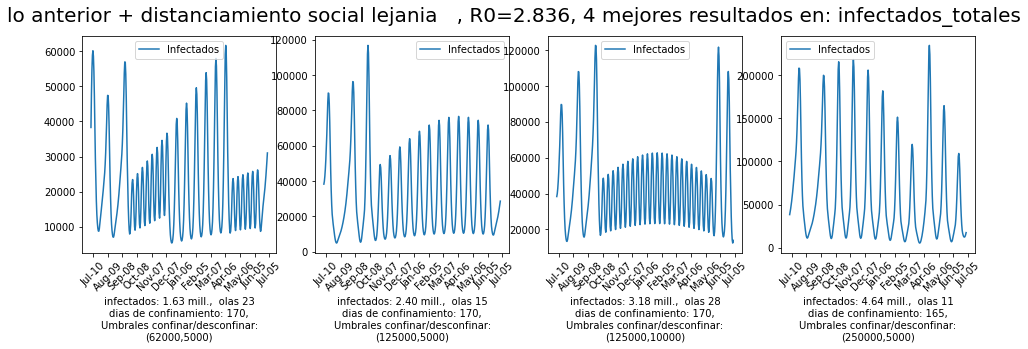

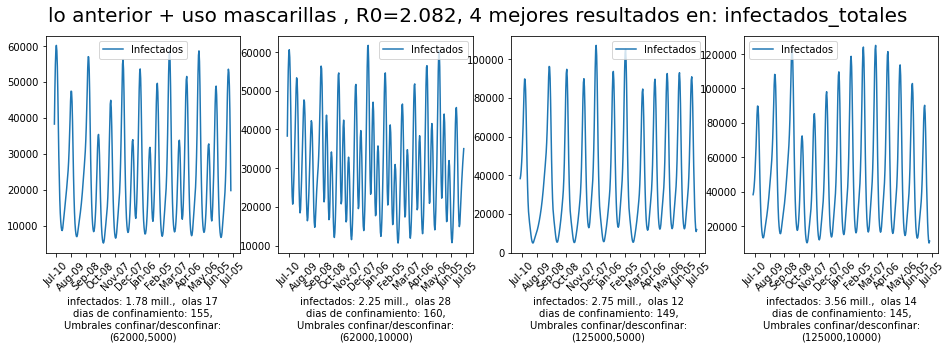

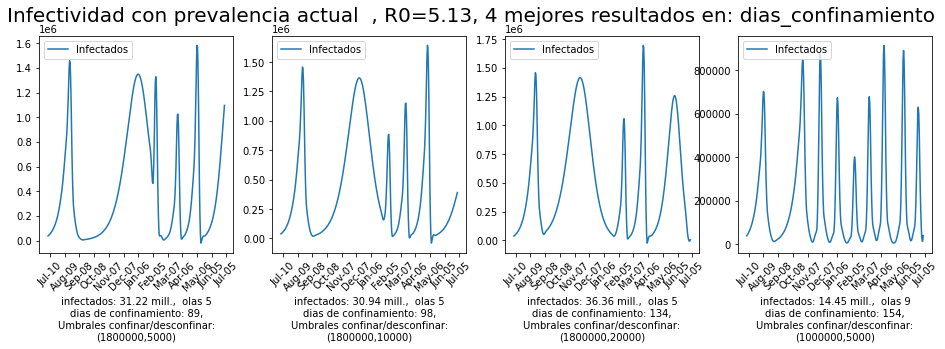

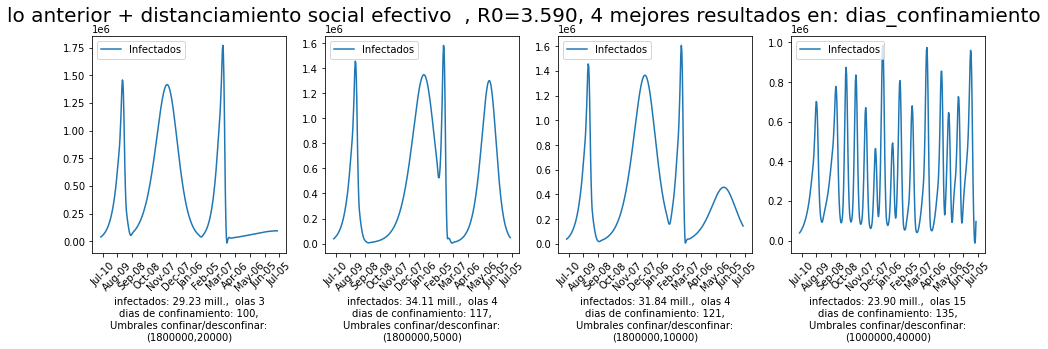

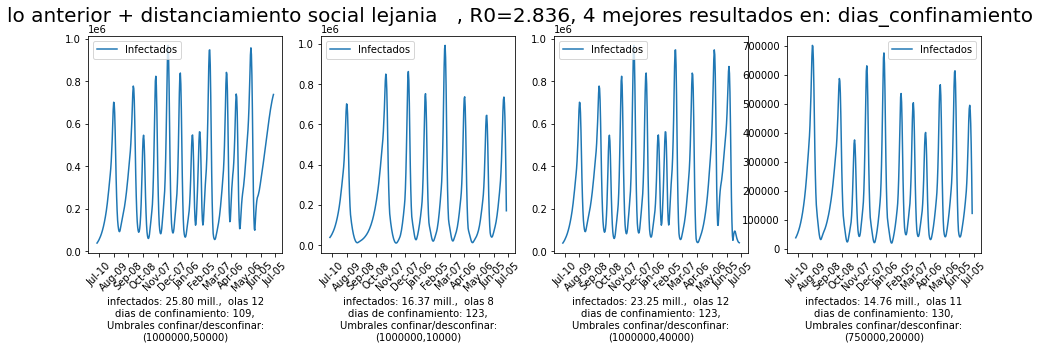

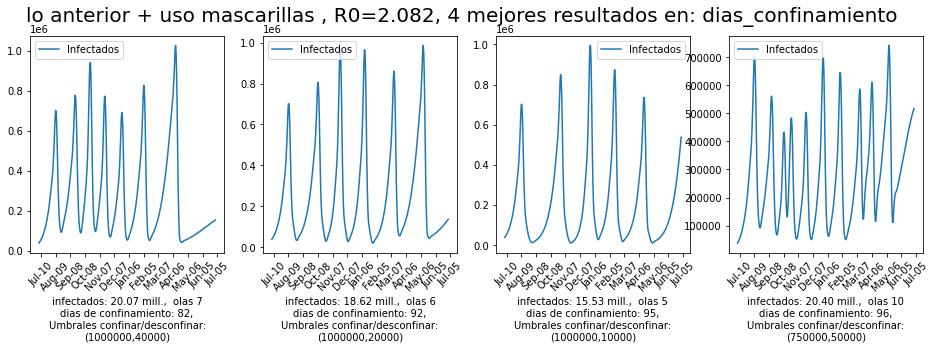

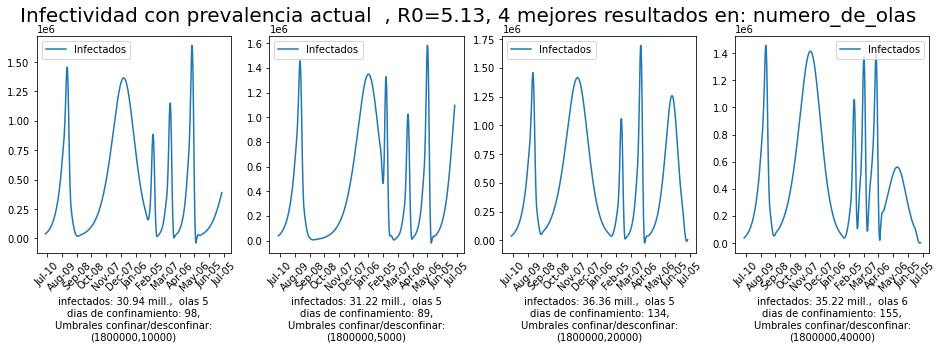

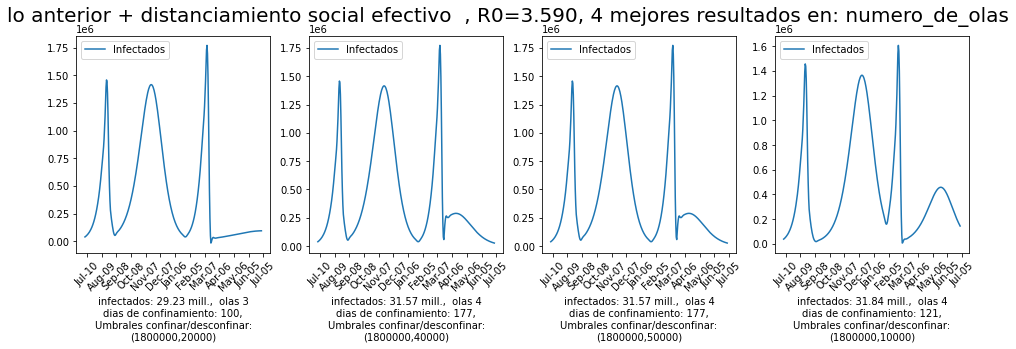

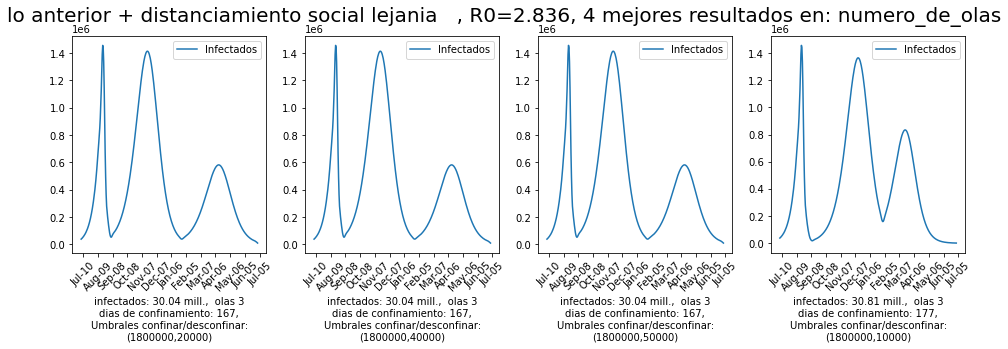

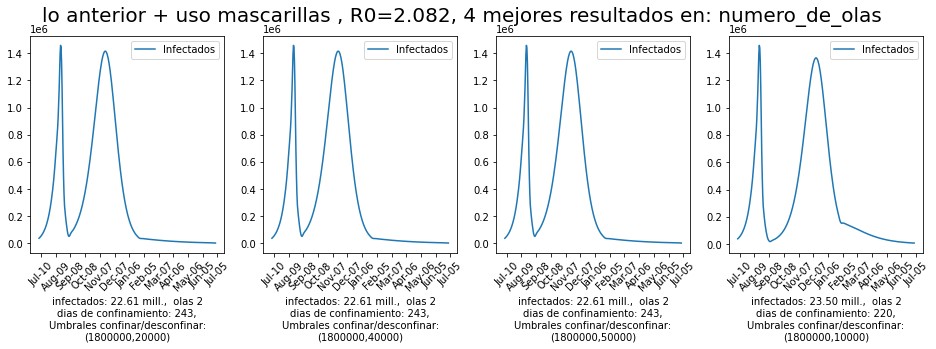

In [18]:
array_parametros_estudio_mascarillas = [
  #  { "descripcion" : "Infectividad con prevalencia original, R0=5.7"             , 'R0' : 5.7   , 'POBLACION_INICIAL_INFECTADA' : 0} ,
    { "escenario": "mascarillas" , "descripcion" : "Infectividad con prevalencia actual  , R0=5.13"            , 'R0' : 5.7     } ,
    { "escenario": "mascarillas" , "descripcion" : "lo anterior + distanciamiento social efectivo  , R0=3.590" , 'R0' : 3.989   } ,
    { "escenario": "mascarillas" , "descripcion" : "lo anterior + distanciamiento social lejania   , R0=2.836" , 'R0' : 3.1515  } ,
    { "escenario": "mascarillas" , "descripcion" : "lo anterior + uso mascarillas , R0=2.082"                  , 'R0' : 2.314   } ,
]

dict_default_values ={
    'FECHA_FINAL_STR'             : '2021-07-01',
    'FECHA_INICIAL_STR'           : '2020-07-01',
    'POBLACION_INICIAL_INFECTADA' :  4500000    , 
    "R0_min"                      :  0.43       ,
    "SITUACION_INICIAL"           :  25000 
    }

mascarillas = Generar_Datos_Conjunto_Escenarios(array_parametros_estudio_mascarillas,dict_default_values,"Estudio de Mascarillas")
Mostrar_Resultados_Conjunto_Escenarios(mascarillas)


## Segunda hipotesis : Airborne

Que el virus sea aerotransportado

Es decir, que la capacidad principal de propagación del virus sea a traves del aire.


De ser esto cierto, las mascarillas jugarían un papel fundamental.

Esta hipotesis sigue este estudio https://www.pnas.org/content/early/2020/06/10/2009637117, y las R0 son calculadas a partir del mismo 

/root/anaconda2/envs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


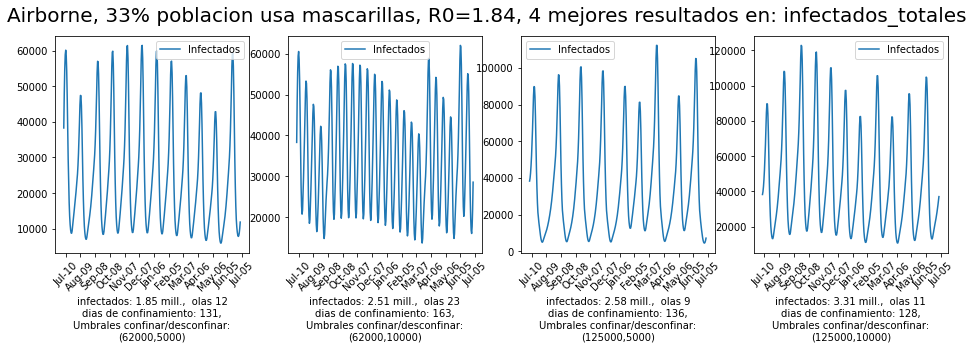

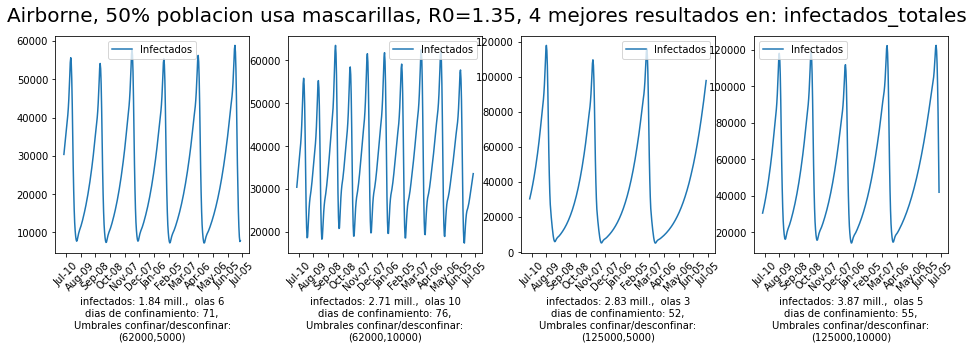

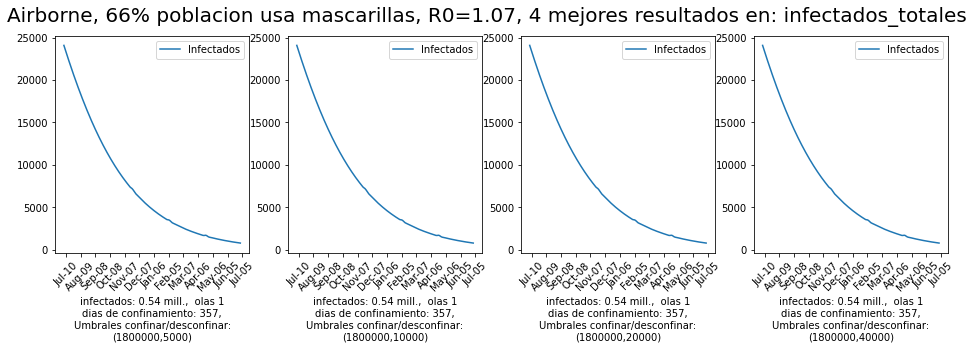

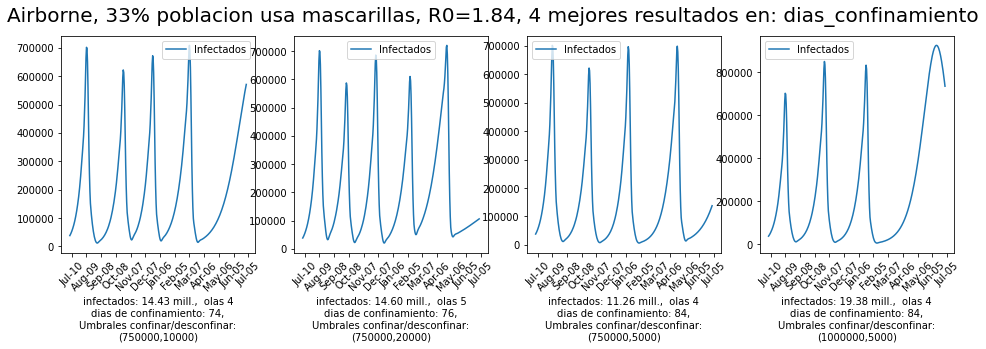

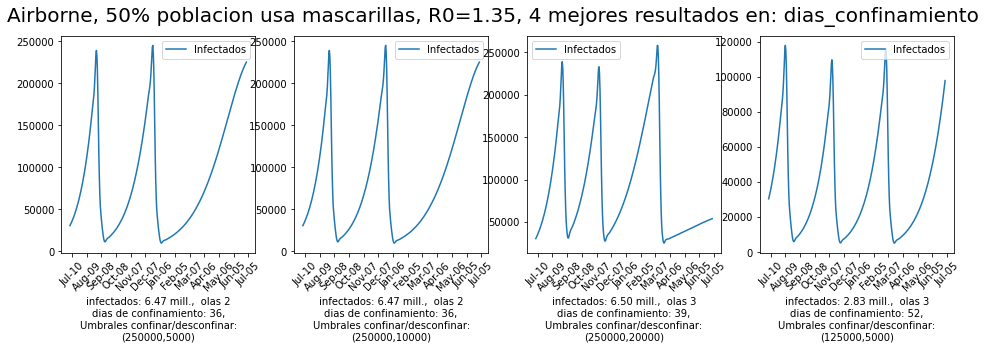

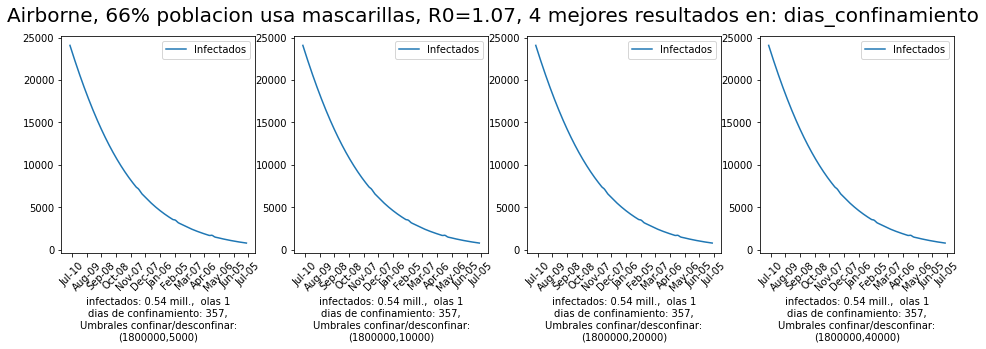

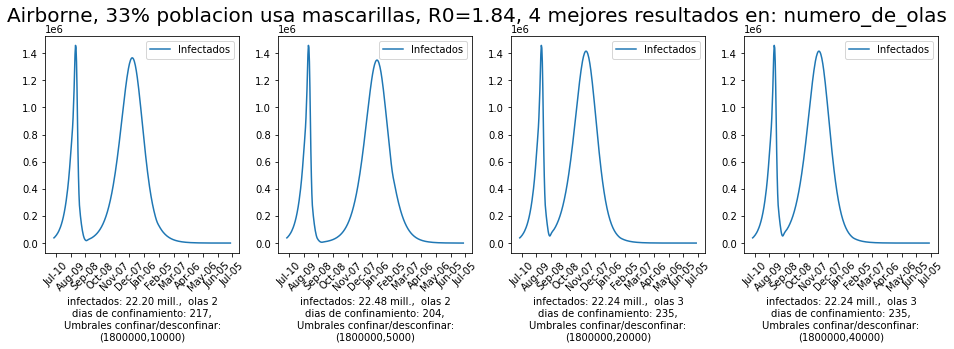

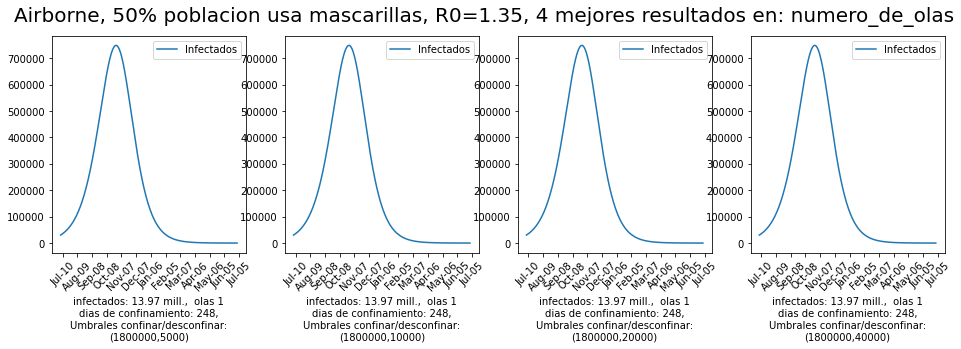

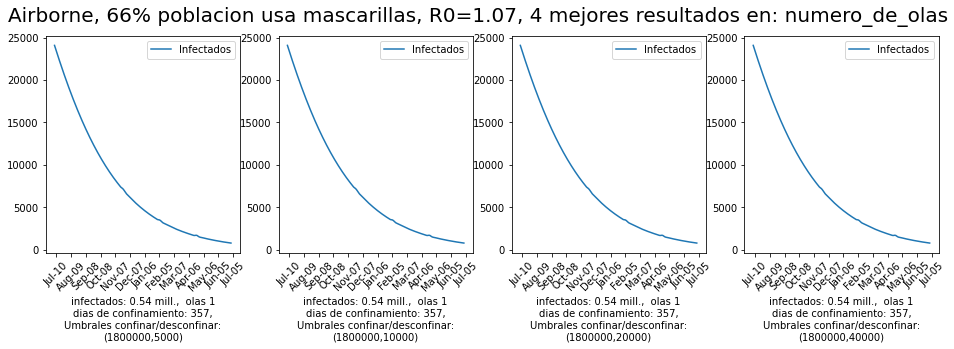

In [19]:
array_parametros_airborne = [
    { "escenario": "airborne" ,  "descripcion" : "Airborne, 33% poblacion usa mascarillas, R0=1.84" , 'R0' : 1.84   , 'POBLACION_INICIAL_INFECTADA' : 4500000 , 'GENERACIONES_SUBIDA' : 25 , 'GENERACIONES_BAJADA' : 25} ,
    { "escenario": "airborne" ,"descripcion" : "Airborne, 50% poblacion usa mascarillas, R0=1.35" , 'R0' : 1.35   , 'POBLACION_INICIAL_INFECTADA' : 4500000 , 'GENERACIONES_SUBIDA' : 25 , 'GENERACIONES_BAJADA' : 25} ,
    { "escenario": "airborne" , "descripcion" : "Airborne, 66% poblacion usa mascarillas, R0=1.07" , 'R0' : 1.07   , 'POBLACION_INICIAL_INFECTADA' : 4500000 , 'GENERACIONES_SUBIDA' : 25 , 'GENERACIONES_BAJADA' : 25} ,
    
]
dict_default_values ={'FECHA_FINAL_STR': '2021-07-01',
 'FECHA_INICIAL_STR': '2020-07-01',
 'POBLACION_INICIAL_INFECTADA': 4500000,
 'R0_min': 0.43,
 'SITUACION_INICIAL': 25000}
airborne = Generar_Datos_Conjunto_Escenarios(array_parametros_airborne,dict_default_values,"Analisis airborne medio de transporte")
Mostrar_Resultados_Conjunto_Escenarios(airborne)


Conclusiones del estudio de la hipotesis, el virus es aerotransportado.

Las cifras de R0 de este estudio son mas bajas que las de otros, y abundan en la importancia de las mascarillas frente al confinamiento.

Una conclusión es que, de ser veraz el estudio, basta con que dos de cada 3 personas llevaran mascarillas, para que la epidemia se autoextinguiera - pero si baja del 66% al 50 %, ya no se extingue y habría al menos 2 millones de infectados. 

Es decir, que en este esecenario un 13% de personas que lleven mascarilla es la diferencia entre que vivan o mueran unas 5.000 personas.


In [20]:
# Funciones de debug
"""import janitor
#df_results = pd.DataFrame(results_array)
#df_results

df  = pd.DataFrame(simulation_get_from_file('simulacion_all.pickle'))
df_extract =pd.DataFrame(
    df
    .filter_on('descripcion == "lo anterior + uso mascarillas , R0=2.082"'  )
    .filter_on('Umbral_max == 125000'  )
    .filter_on('Umbral_min == 5000'  )
    [['df']]
)
pd.set_option('display.max_rows', 365)

df_temp = pd.DataFrame(df_extract.df.iloc[0])
#df_temp
  """


'import janitor\n#df_results = pd.DataFrame(results_array)\n#df_results\n\ndf  = pd.DataFrame(simulation_get_from_file(\'simulacion_all.pickle\'))\ndf_extract =pd.DataFrame(\n    df\n    .filter_on(\'descripcion == "lo anterior + uso mascarillas , R0=2.082"\'  )\n    .filter_on(\'Umbral_max == 125000\'  )\n    .filter_on(\'Umbral_min == 5000\'  )\n    [[\'df\']]\n)\npd.set_option(\'display.max_rows\', 365)\n\ndf_temp = pd.DataFrame(df_extract.df.iloc[0])\n#df_temp\n  '

## 3º Hipotesis, ¿ Habrá ola durante el verano. ?

Vamos a extrapolar los datos de muertes en Madrid, para estimar el nº de infectados, y probar con distintos valores de R0 durante el verano para saber si habrá segunda ola en verano.


In [21]:
MADRID_MUERTES=15000
MADRID_CASOS_PCR=323000
MADRID_CASOS_POR_PREVALENCIA=7000000*0.1

MADRID_MUERTES=15000
MADRID_CASOS_PCR=323000
MADRID_CASOS_POR_PREVALENCIA=7000000*0.1
MADRID_CASOS_TOTALES_POR_MUERTE=MADRID_CASOS_POR_PREVALENCIA/MADRID_MUERTES
#MADRID_CASOS_TOTALES_POR_MUERTE
#46.666666666666664
MADRID_MUERTES_DIARIAS_MA=13
ESTIMACION_CASOS_MADRID=MADRID_MUERTES_DIARIAS_MA*MADRID_CASOS_TOTALES_POR_MUERTE
#ESTIMACION_CASOS_MADRID
#606.6666666666666
# MADRID REPRESENTA 1/3 CASOS TOTALES. ASI QUE

ESTIMACION_CASOS_ESPAÑA=ESTIMACION_CASOS_MADRID*3
ESTIMACION_CASOS_ESPAÑA
#1820
ESTIMACION_CASOS_ESPAÑA_DIARIA=ESTIMACION_CASOS_MADRID*3
ESTIMACION_CASOS_ESPAÑA_EN_UNA_GENERACION_INFECCION=ESTIMACION_CASOS_ESPAÑA_DIARIA*5
ESTIMACION_CASOS_ESPAÑA_EN_UNA_GENERACION_INFECCION
#9100
ESTIMACION_CASOS_ESPAÑA_EN_UNA_GENERACION_INFECCION=9100
ESTIMACION_CASOS_ESPAÑA_EN_UNA_GENERACION_INFECCION

9100

/root/anaconda2/envs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/root/anaconda2/envs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


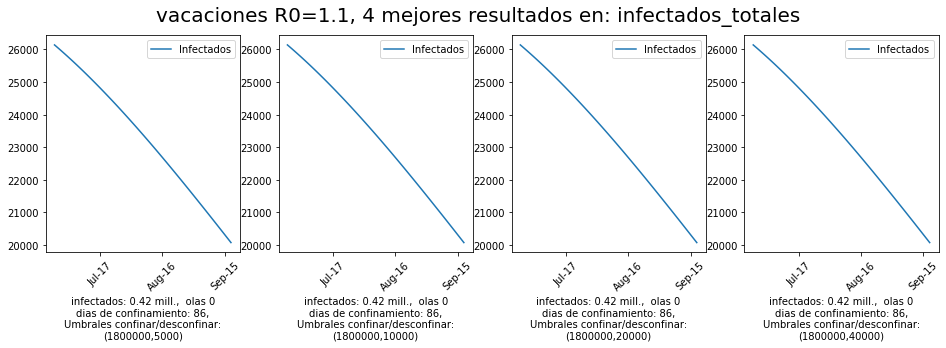

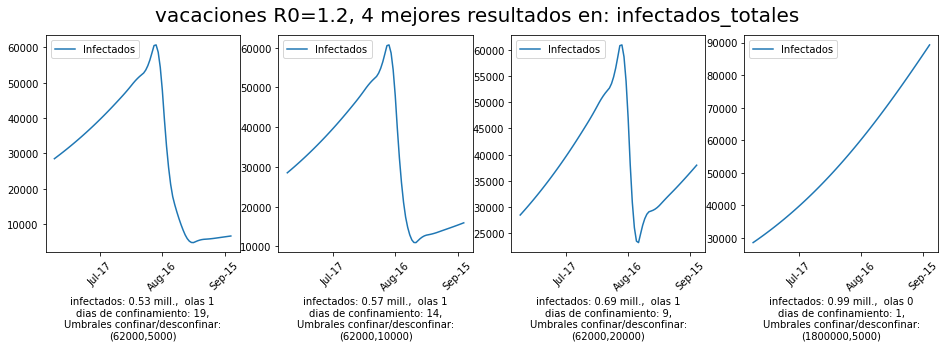

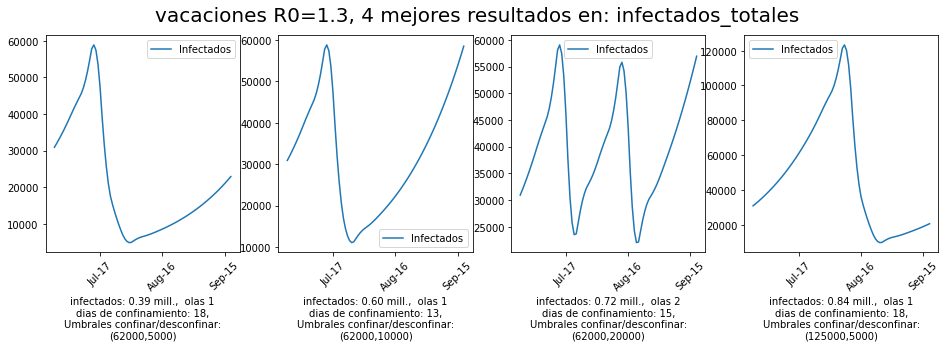

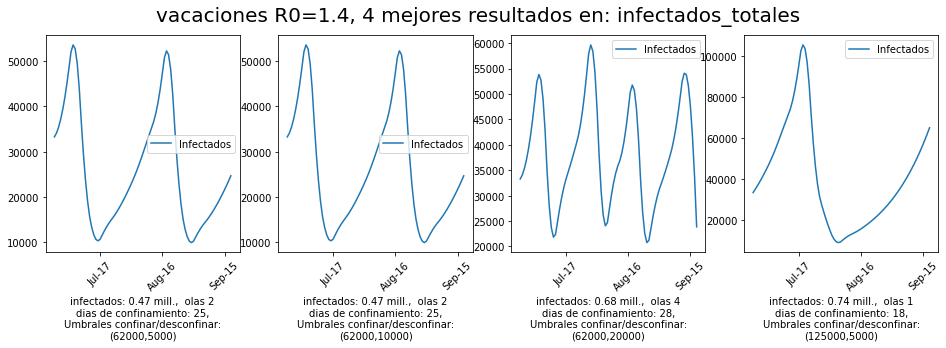

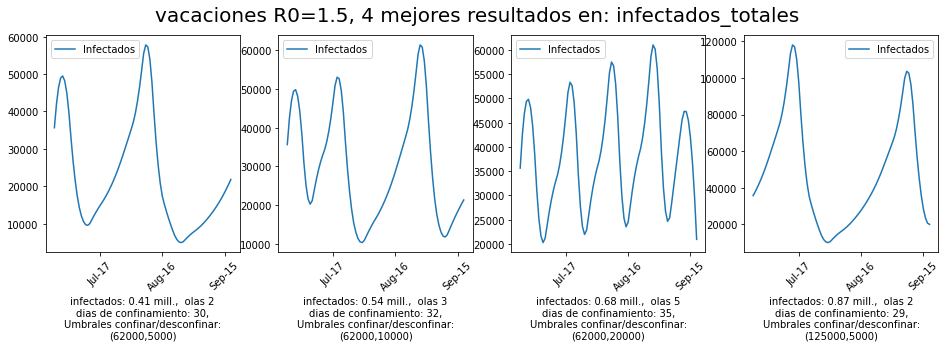

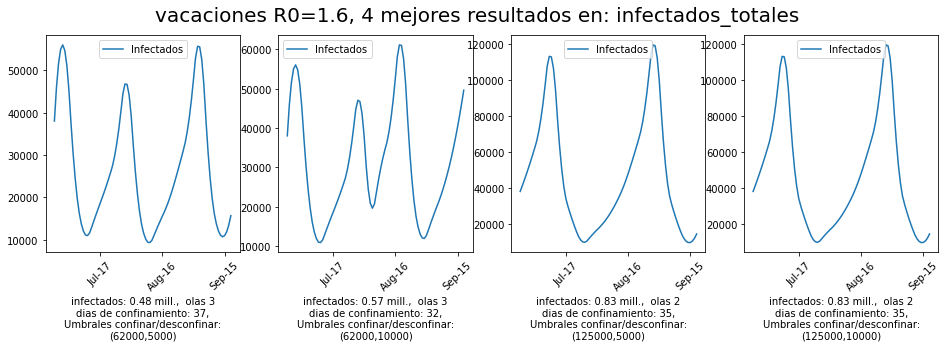

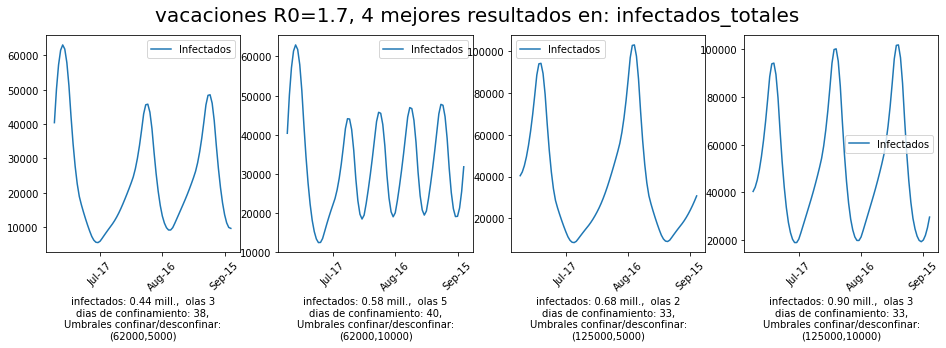

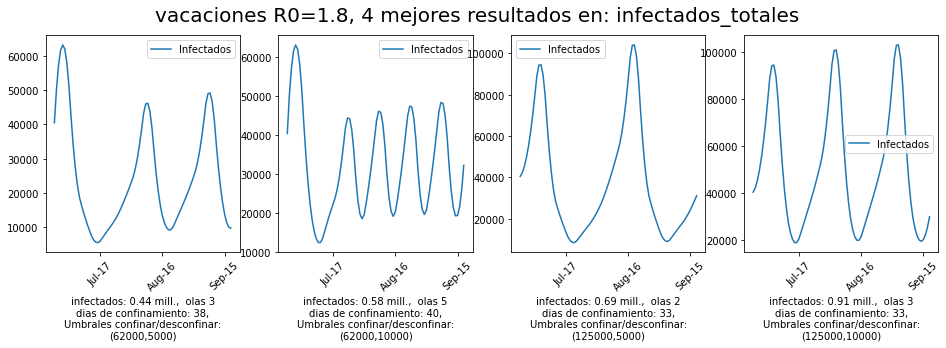

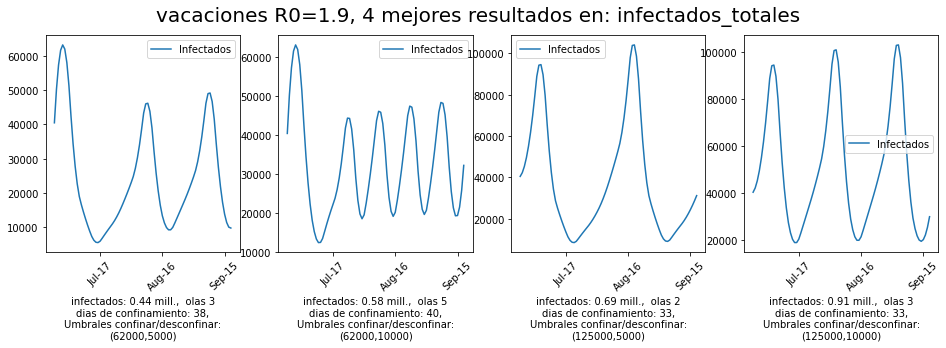

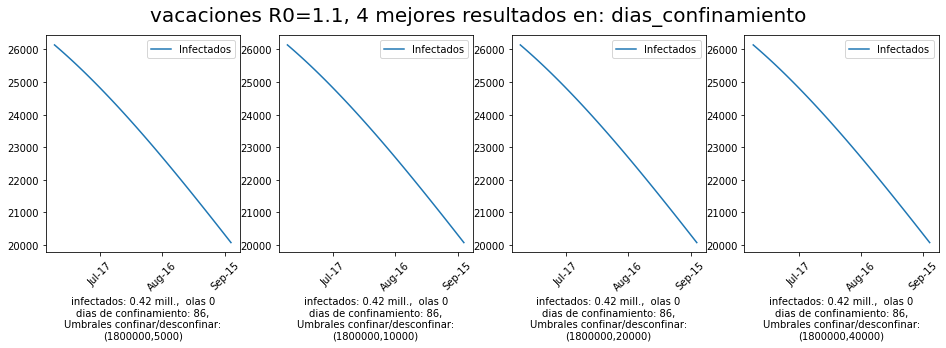

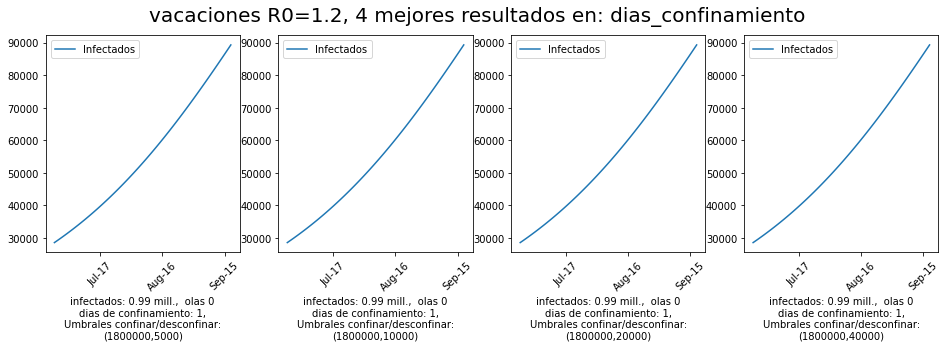

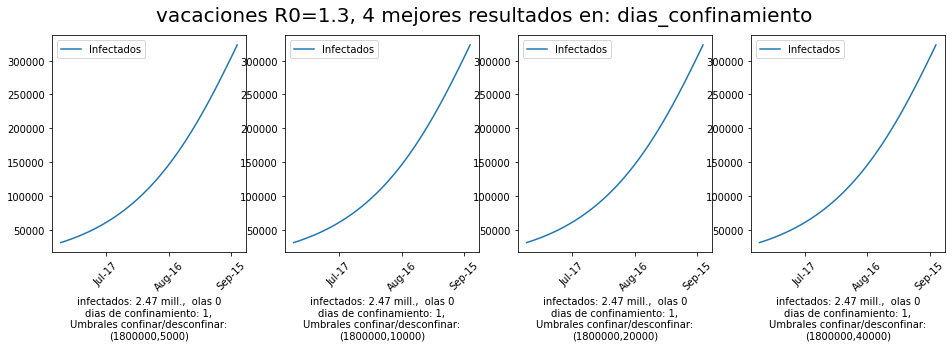

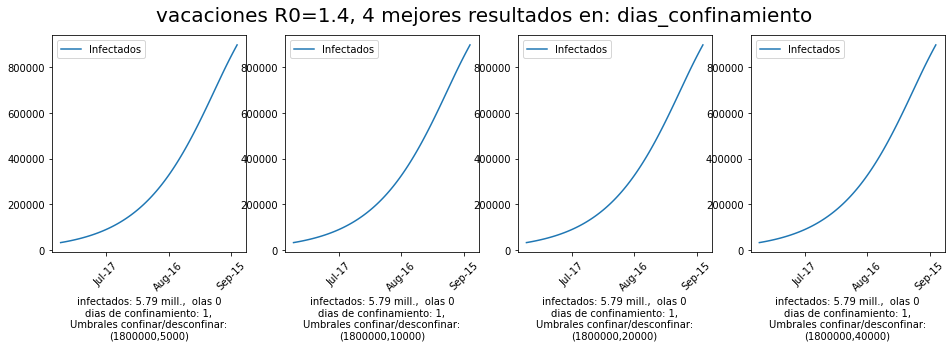

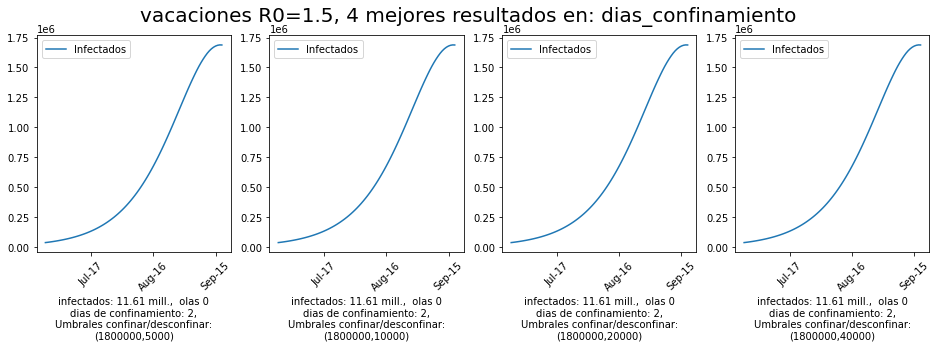

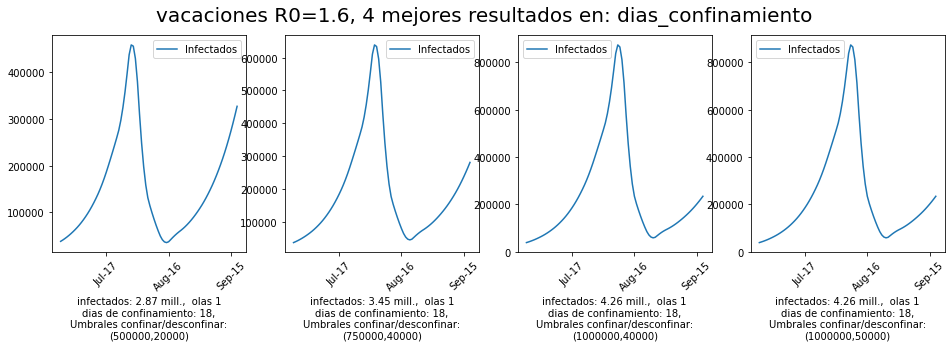

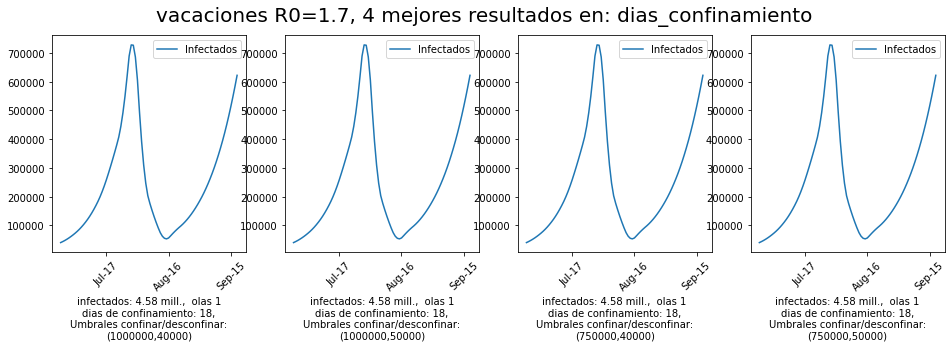

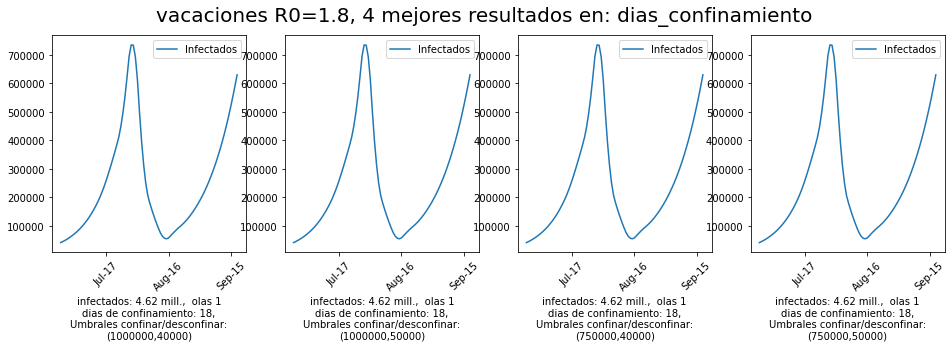

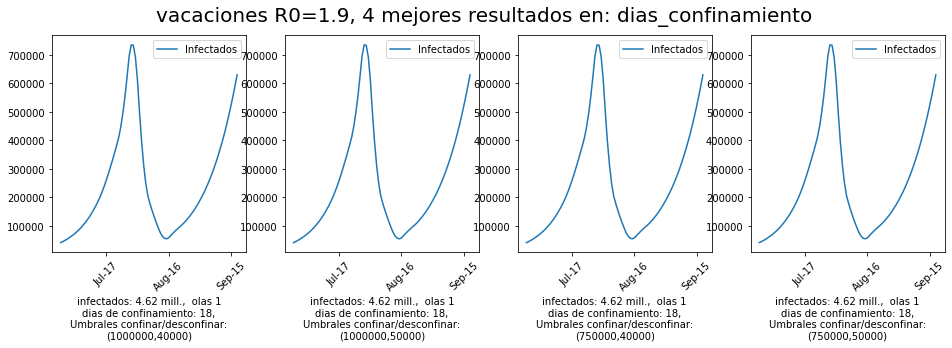

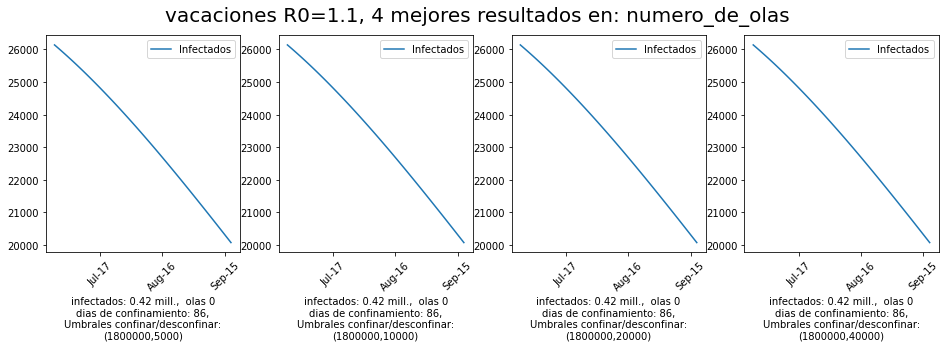

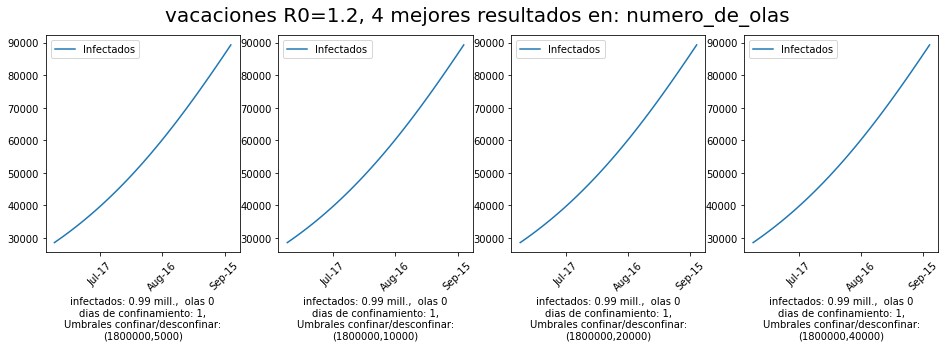

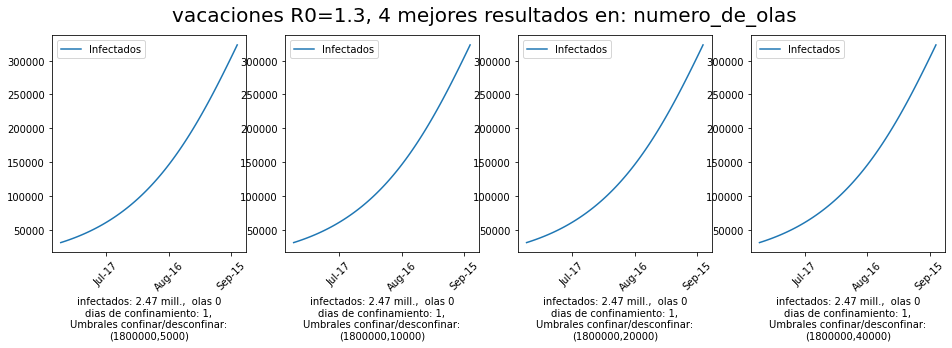

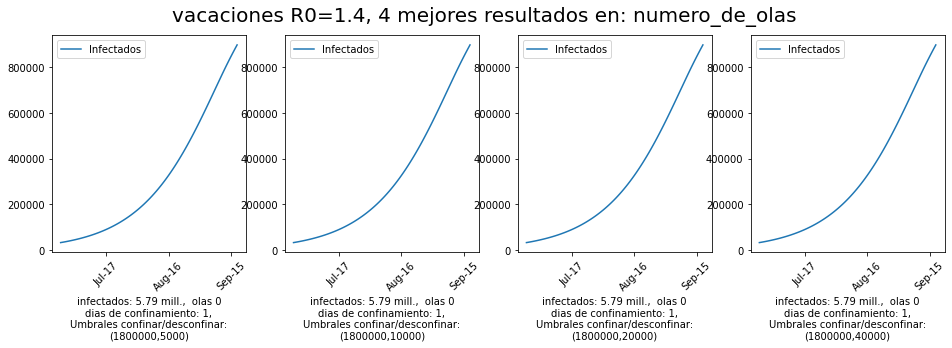

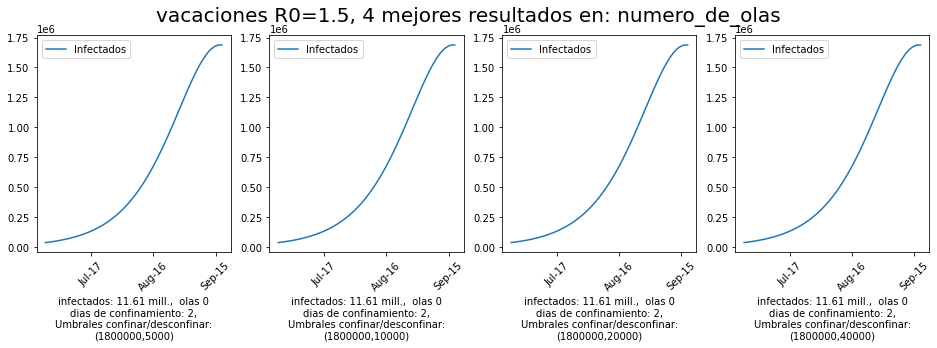

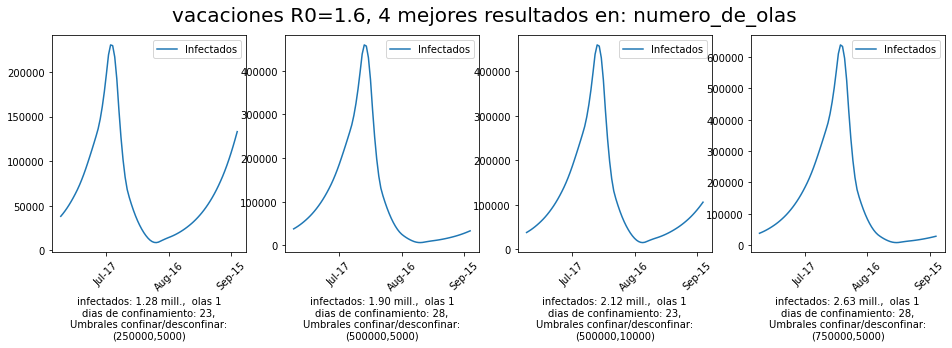

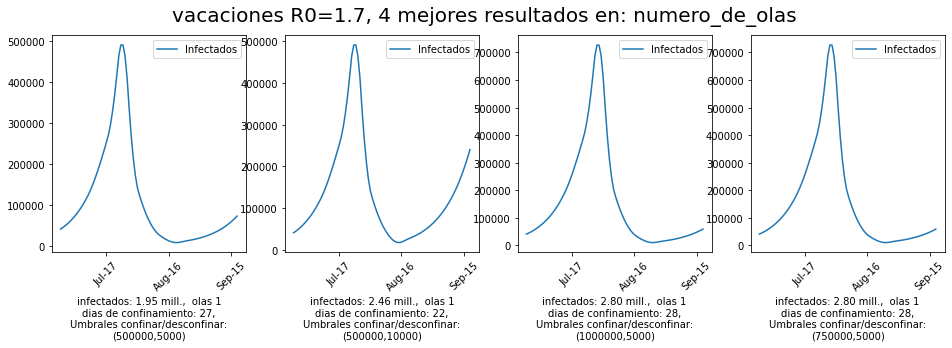

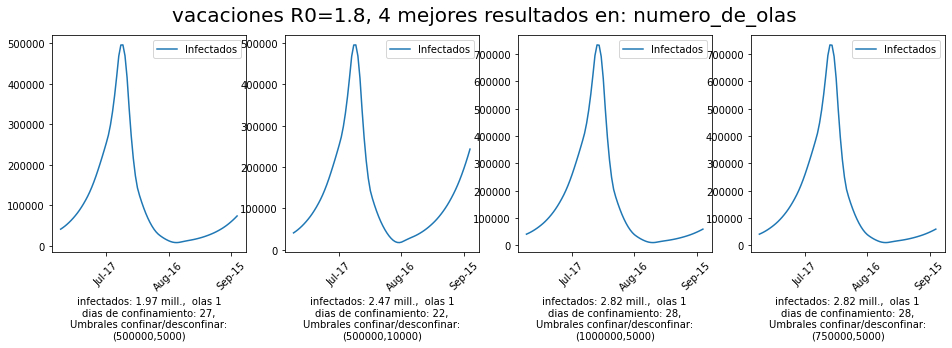

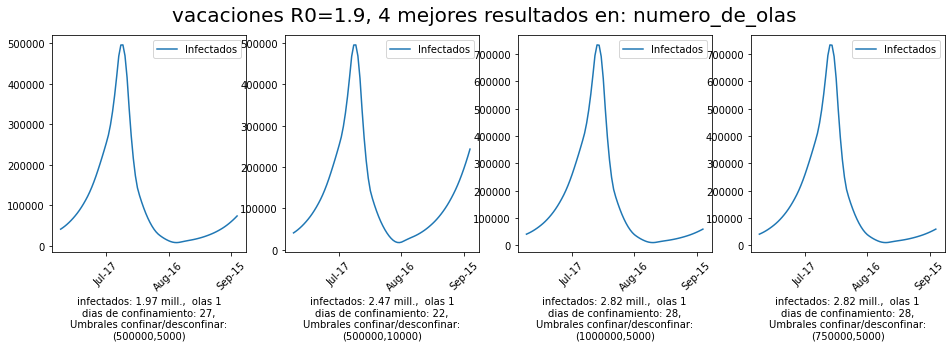

In [24]:
ESTIMACION_CASOS_ESPAÑA_EN_UNA_GENERACION_INFECCION=26400
array_parametros_estudio_vacaciones = [ 
 { "escenario": "vacaciones" , "descripcion" : "vacaciones R0=1.1" ,"RO_calor" : 1.10 ,  "R0" : 1.1} ,
 { "escenario": "vacaciones" , "descripcion" : "vacaciones R0=1.2" ,"RO_calor" : 1.20  , "R0" : 1.2} ,
 { "escenario": "vacaciones" , "descripcion" : "vacaciones R0=1.3" ,"RO_calor" : 1.30  , "R0" : 1.3} ,
 { "escenario": "vacaciones" , "descripcion" : "vacaciones R0=1.4" ,"RO_calor" : 1.40  , "R0" : 1.4} ,
 { "escenario": "vacaciones" , "descripcion" : "vacaciones R0=1.5" ,"RO_calor" : 1.50  , "R0" : 1.5} ,
 { "escenario": "vacaciones" , "descripcion" : "vacaciones R0=1.6" ,"RO_calor" : 1.60  , "R0" : 1.6} ,
 { "escenario": "vacaciones" , "descripcion" : "vacaciones R0=1.7" ,"RO_calor" : 1.70  , "R0" : 1.7} ,
 { "escenario": "vacaciones" , "descripcion" : "vacaciones R0=1.8" ,"RO_calor" : 1.80  , "R0" : 1.8} ,
 { "escenario": "vacaciones" , "descripcion" : "vacaciones R0=1.9" ,"RO_calor" : 1.90  , "R0" : 1.9} 
]


dict_default_values = {
    "R0_min" : 0.5,
    "SITUACION_INICIAL" : ESTIMACION_CASOS_ESPAÑA_EN_UNA_GENERACION_INFECCION  ,
    "FECHA_INICIAL_STR" : '2020-06-20'  ,
    "FECHA_FINAL_STR"   : '2020-09-20'  ,
    'GENERACIONES_SUBIDA' : 1 , 'GENERACIONES_BAJADA' : 1,
    'POBLACION_INICIAL_INFECTADA' : 4500000  
    }

        

vacaciones = Generar_Datos_Conjunto_Escenarios(array_parametros_estudio_vacaciones,dict_default_values,"Vacaciones")
Mostrar_Resultados_Conjunto_Escenarios(vacaciones)


### Conclusiones del estudio de vacaciones

Este modelo es <strong>muy sensible a las condiciones iniciales</strong> - cuando empiezan a subir las <strong>temperaturas</strong>, y el uso de <strong>mascarillas</strong>.
Si se cumplen <strong>ambas condiciones</strong>, es posible que aguantasemos <strong>sin confinamientos</strong>, si logramos mantener el R0<1.3.

<strong>Aún en el caso de que no lográramos mantener bajo el R0</strong>, si hicieramos confinamiento, y fueramos lo bastante previsores <strong>con los umbrales de confinamiento</strong> y desconfinamiento, podriamos <strong>mantener bajo el número de infectados</strong> - medio millón de infectados, unas 1200 muertes.



In [ ]:
pd.DataFrame(vacaciones[0]['df'])

In [ ]:
# Nos quedamos solo con los mejores resultados 
import janitor
df = pd.concat([pd.DataFrame(airborne),pd.DataFrame(mascarillas)])
df = df.drop('df', axis=1)
array_results = []
df_escenario=pd.DataFrame()
for escenario in df.descripcion.unique():
    df_escenario = df.filter_on(f"""descripcion == '{escenario}'"""  )
    criterio = ['infectados_totales', 'Umbral_max']
    criterio_order = [True, True]
    df_escenario.sort_values(by = criterio,ascending=criterio_order ,inplace=True)
    df_escenario=df_escenario.head(5)
    array_results.append(df_escenario)
    
df =pd.concat(array_results)


#df['Division umbrales maximo y minimo'] = df.Umbral_max / df.Umbral_min

In [ ]:
import seaborn as sns
print("Relacion dias de R0 ,  Infectados totales y umbral máximo de confinamiento")
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [15, 7]})

ax = sns.scatterplot(x='R0', y="infectados_totales", hue = 'Umbral_max',
                     data=df )



Aquí si se ve como una buena política de confinamiento sería atajar los brotes cuanto antes - umbral bajo de confinamiento y desconfinamiento-, independiemente del R0.



In [ ]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    df['dias_confinamiento'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='dias_confinamiento', ylabel='Count');


In [ ]:
df.columns

numerical = [ "dias_confinamiento", "infectados_totales", "numero_de_olas", "R0"]
categorical = [ "escenario", "descripcion"] 


In [ ]:
df[numerical].hist(bins=15, figsize=(15, 6), layout=(2, 4));


In [ ]:
sns.countplot(df['escenario']);


In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(df[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

In [ ]:

fig, ax = plt.subplots(3, 3, figsize=(15, 10))
for var, subplot in zip(categorical, ax.flatten()):
    sns.boxplot(x=var, y='SalePrice', data=df, ax=subplot)

In [ ]:
sns.scatterplot(x="dias_confinamiento", y="infectados_totales");
